# Supervised learning

In [1]:
import sys
assert sys.version_info >= (3, 7)

import pandas as pd
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:

from pathlib import Path
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



# Import dataset and explore it

In [3]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)


# Get class as y
y = df['Contraceptive_method_used']


In [4]:
X

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [5]:
y.value_counts()

Contraceptive_method_used
1    629
3    511
2    333
Name: count, dtype: int64

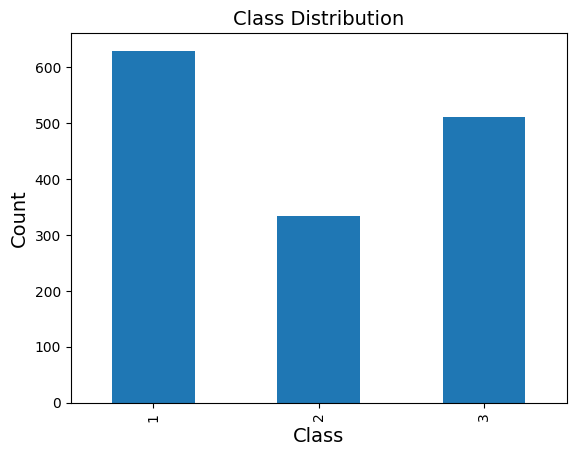

In [6]:
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


# Description of Dataset
The dataset is focused in predicting contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics. The samples come from a subset of the 1987 National Indonesia Contraceptive Prevalence Survey and they contain married women who were either not pregnant or do not know if they were at the time of interview.

It has 1473 instances with 10 features including the class. Information of the features:

* Wife's age (16-49): numerical
* Wife's education (categorical) 1=low, 2, 3, 4=high
* Husband's education (categorical) 1=low, 2, 3, 4=high
* Number of children ever born (0-16): numerical
* Wife's religion (binary) 0=Non-Islam, 1=Islam
* Wife's now working? (binary) 0=Yes, 1=No
* Husband's occupation (categorical) 1, 2, 3, 4
* Standard-of-living index (categorical) 1=low, 2, 3, 4=high
* Media exposure (binary) 0=Good, 1=Not good
* Contraceptive method used (class attribute) 1=No-use 2=Long-term 3=Short-term

(OpenMl, n.d.)

In this case, the categorical features are set as nominal, but if we observe there are some that may seem as ordinal because they use a low to high scale. For that reason, one of the aims is to treat those features as ordinal and the other is to treat it as nominal. After doing this, the performance will be evaluated to assess which option is the best. There are also no Nan values in the dataset.

As we can see above the classes are a bit unbalanced, because class 1 is 42.7% of the dataset, while class 2 is 34.69% and class 3 is 22.60%. So even if they don't have the same number of samples, they are still close to each other.

# Compare results with OneHotEncoder for the categorical variables
We will use OneHotEncoder for this because it allows us to separate the variables in a way in which we don't give more weight to a value. We will also scale the numeric variables, to avoid bias.

# Default Decision Tree
**OneHotEncoder just for Husbands_occupation**

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder



# Only convert categorical feature of Husband's occupation.
categorical_features = ['Husbands_occupation']
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]
ordinal_features = ["Wifes_education", "Husbands_education", "Standard-of-living_index"]

# Create pipline for numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Split dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Results for Default Tree 
**OneHotEncoder just for Husbands_occupation**

In [10]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("First example with 'Husbands_occupation':")
print(f"Tree depth: {pipeline.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

First example with 'Husbands_occupation':
Tree depth: 23
              precision    recall  f1-score   support

           1       0.65      0.63      0.64       130
           2       0.44      0.39      0.41        71
           3       0.40      0.45      0.42        94

    accuracy                           0.52       295
   macro avg       0.50      0.49      0.49       295
weighted avg       0.52      0.52      0.52       295



In [11]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['num__Wifes_age' 'num__Number_of_children_ever_born'
 'cat__Husbands_occupation_2' 'cat__Husbands_occupation_3'
 'cat__Husbands_occupation_4' 'binary__Wifes_religion'
 'binary__Wifes_now_working%3F' 'binary__Media_exposure'
 'ordinal__Wifes_education' 'ordinal__Husbands_education'
 'ordinal__Standard-of-living_index']


# Default Tree 
**OneHotEncoder for all categorical variables**n**

In [12]:

categorical_features2 = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]

numeric_transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer2, numeric_features),
        ("cat", categorical_transformer2, categorical_features2),
        ('binary', 'passthrough', binary_features) 
    ]
)

pipeline2 = Pipeline([
    ("preprocessor", preprocessor2),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_test)

print(f"Tree depth: {pipeline2.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

Tree depth: 22
              precision    recall  f1-score   support

           1       0.60      0.65      0.62       130
           2       0.38      0.35      0.36        71
           3       0.44      0.43      0.43        94

    accuracy                           0.51       295
   macro avg       0.48      0.47      0.47       295
weighted avg       0.50      0.51      0.50       295



In [13]:
from sklearn import set_config
set_config(transform_output='pandas')  # For easier inspection (scikit-learn >=1.2)

X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
print(X_train_transformed.shape)

print("Train accuracy:", pipeline.score(X_train, y_train))
print("Test accuracy:", pipeline.score(X_test, y_test))

(1178, 11)
Train accuracy: 0.9584040747028862
Test accuracy: 0.5152542372881356


/Users/paulinalealmosqueda/anaconda3/envs/IDM/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/paulinalealmosqueda/anaconda3/envs/IDM/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Therefore, the results with only the best results are obtained by transforming only the categorical feature of Husband's occupation. We will treat all categorical variables as ordinal, except from this one. It is now possible to create a fine-tuned decision tree by converting the categorical features using OneHotEncoder. Since the maximum depth of the default tree was 23, we'll set the height to 30 to have a margin of error.

Now, we need to decide the performance measure that we'll use. In this case, accuracy is not the best option because the decision will give more weight to class 1, given the initial class distribution that we saw first, which was moderately unbalanced. If we choose precision, we would overlook some of the classes. Thus, the model loses information about the woman's choice based on her characteristics. On the other hand, if we only use recall, the model may misclassify some classes, which would generate false conclusions and ultimately affect the interpretation of how women choose their contraceptive method. Therefore, in this case, the performance measure will be the F1-score because it is the harmonic mean of precision and recall, which means that we will consider both measures. 

Since the dataset is slightly unbalanced we'll use stratified folds, so that the folds contain a representative ratio of each class.

# Preprocessing

In [14]:

# Only convert categorical feature of Husband's occupation.
categorical_features = ['Husbands_occupation']
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]
ordinal_features = ["Wifes_education", "Husbands_education", "Standard-of-living_index"]

# Create pipline for numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ]
)


# Decision Tree

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report


cv = StratifiedKFold(n_splits=16, shuffle=True, random_state=42)



param_grid = {
    'classifier__max_depth': [None, 5, 10, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=cv,
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_


y_pred = best_tree.predict(X_test)

print(classification_report(y_test, y_pred))
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

              precision    recall  f1-score   support

           1       0.70      0.60      0.65       130
           2       0.49      0.45      0.47        71
           3       0.47      0.60      0.53        94

    accuracy                           0.56       295
   macro avg       0.56      0.55      0.55       295
weighted avg       0.58      0.56      0.57       295

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Best weighted F1 score: 0.5501516726839839


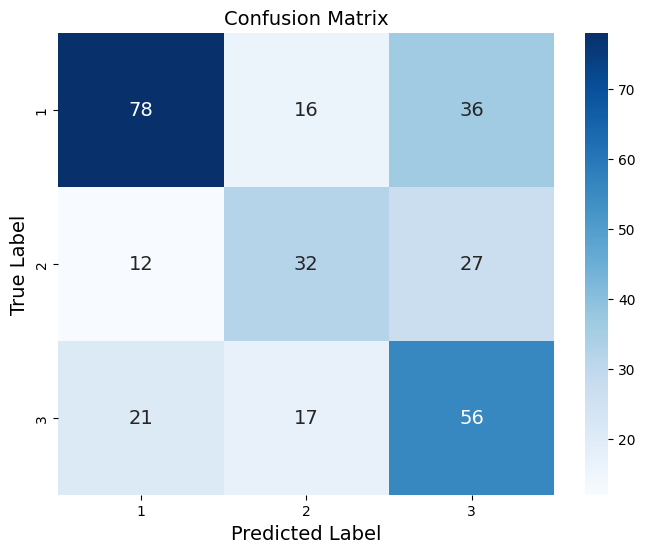

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = best_tree.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
best_dt = best_tree.named_steps['classifier']
feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()


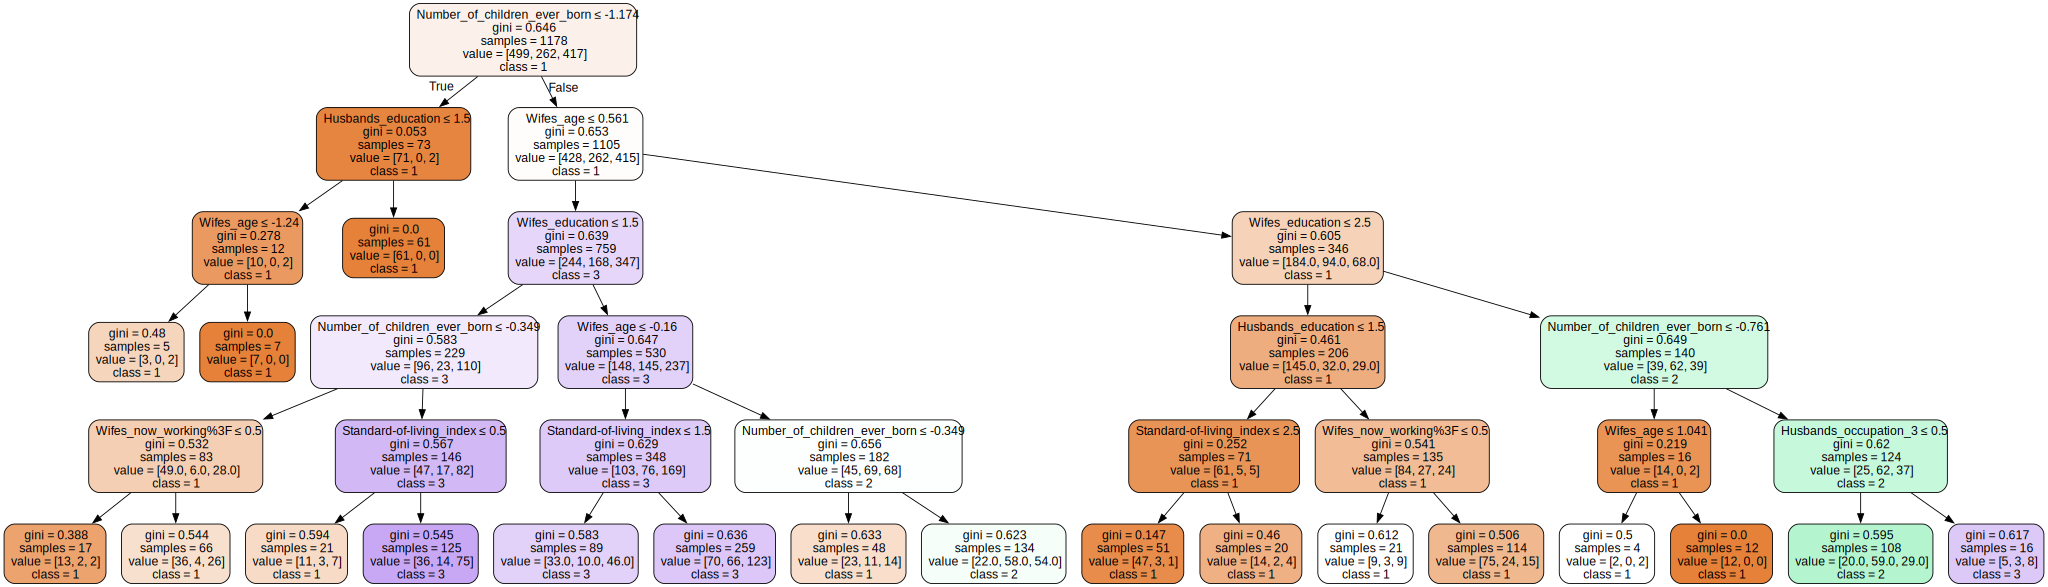

In [18]:
from sklearn.tree import export_graphviz
from graphviz import Source


feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()

dot_path = IMAGES_PATH / "best_tree.dot"


clean_feature_names = []
for name in feature_names:
    clean_name = name.split('__')[-1]
    clean_feature_names.append(clean_name)



export_graphviz(
    best_dt,
    out_file=str(dot_path),
    feature_names=clean_feature_names,  
    class_names=["1", "2", "3"],
    rounded=True,
    filled=True,
    special_characters=True,
)


Source.from_file(dot_path)

We chose 16 splits for StratifiedKFold because this combination gave the best result for the f1-score after trying different values.

# KNeighborsClassifier
Paulina Leal

It's a non-parametric supervised learning classifier, which uses proximity to make classifications it works by the assumption that similar points can be found near one another. The value of k represents how many neighbors will be checked to determine the classification of a specific point. It is usually recommended to use odd numbers, to avoid ties in classification.


| Advantages                                                               | Disadvantages         
| -------------------------------------------------------------------------| -------------------------------------------------------------------------------------------------------|
| Adapts easily: the algorithms adjusts to account for any new data.       | Data does not scale well: time consuming, it takes memory and data storage.                            |
| Few hyperparameters: only needs k value and distance metric              | Doesn't perform well with high-dimensional data inputs.                                                | 
| Easy to implement                                                        | Prone to overfitting: lower values of k can overfit data and higher values smooth out the data         |
|                                                                          | If k value is too high it can underfit data.                                                           |

(IBM, s.f.)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold


knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': list(range(1, 40)),
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)


grid_search_knn = GridSearchCV(estimator=knn_model,param_grid=param_grid,cv=cv,scoring='f1_weighted',n_jobs=-1)


grid_search_knn.fit(X_train, y_train)


best_knn = grid_search_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)


print("Best parameters:", grid_search_knn.best_params_)
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred_knn))
print("Test f1_score:", f1_score(y_test, y_pred_knn, average='weighted'))

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 37, 'classifier__p': 1, 'classifier__weights': 'uniform'}

Classification report on test set:
              precision    recall  f1-score   support

           1       0.70      0.62      0.66       130
           2       0.52      0.41      0.46        71
           3       0.46      0.61      0.52        94

    accuracy                           0.56       295
   macro avg       0.56      0.54      0.54       295
weighted avg       0.58      0.56      0.56       295

Test f1_score: 0.5647545943696712


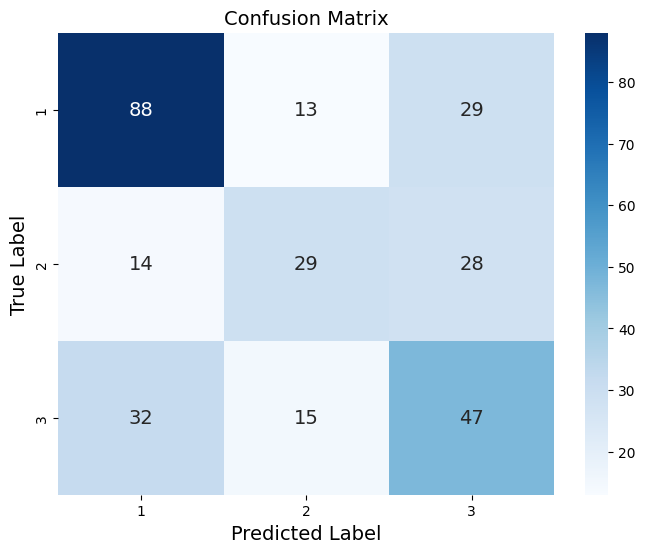

In [20]:
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Results from training and testing
# See if there's any overfitting

# Train the model with X_train
y_train_pred_knn = best_knn.predict(X_train)


print("\nClassification report on training set:")
print(classification_report(y_train, y_train_pred_knn))

# F1 scores for comparison
train_f1 = f1_score(y_train, y_train_pred_knn, average='weighted')
test_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"Train f1_score: {train_f1}")
print(f"Test  f1_score: {test_f1}")




Classification report on training set:
              precision    recall  f1-score   support

           1       0.66      0.70      0.68       499
           2       0.53      0.46      0.49       262
           3       0.58      0.59      0.58       417

    accuracy                           0.61      1178
   macro avg       0.59      0.58      0.58      1178
weighted avg       0.60      0.61      0.60      1178

Train f1_score: 0.6027965507750852
Test  f1_score: 0.5541179806539975


# Justification of hyperparameters

To set the range of k-values it was nessecary to try several ranges and observe which one got the best f1-score overall. At first, the range was set from 1-20 and 1-30, and in both cases the best score was the result was 0.55, with 13 k-values. Then the range was set from 1-40, and the results improved by getting a 0.564 F1 score with 37 values. If we incremented more the number of k neighbors, the result was always the same, so we decided to stay with the range 1-40.

To perform cross-validation, we took into account the fact that the data is not perfectly balanced and we decided to try both StratifiedKFold and RepeatedStratifiedKFold. The values of number of splits where changed several times for both of them, until we got the best result, which was 20 with StratifiedKFold.

Moreover, we tried all of the distance metric and made GridSearch determine which one was the best option.